In [1]:
import pandas as pd
pd.options.mode.chained_assignment = None 
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from pandas_datareader import data as pdr
import yfinance as yf
yf.pdr_override()

In [3]:
from stocktrends import indicators

In [4]:
data={} # Dictionary to contain pandas dataframe for all the stocks. This is to avoid creating variable for each stock 
        # to store data
finalData={} # This should contain our final output and that is Renko OHLC data
n=7 # Period for ATR
renkoData={} # It contains information on the lastest bar of renko data for the number of stocks we are working on

In [5]:
def ATR(df,n): #df is the DataFrame, n is the period 7,14 ,etc
    df['H-L']=abs(df['High']-df['Low'])
    df['H-PC']=abs(df['High']-df['Close'].shift(1))
    df['L-PC']=abs(df['Low']-df['Close'].shift(1))
    df['TR']=df[['H-L','H-PC','L-PC']].max(axis=1)
    df['ATR']=np.nan
    df.loc[df.index[n-1],'ATR']=df['TR'][:n-1].mean() #.ix is deprecated from pandas version- 0.19
    for i in range(n,len(df)):
        df['ATR'][i]=(df['ATR'][i-1]*(n-1)+ df['TR'][i])/n
    return

In [6]:
StockList=['PNB', 'ICICIBANK']

In [7]:
start='2019-1-1'
for stock in StockList:
    data[stock]=pdr.get_data_yahoo(stock+'.NS', start)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [8]:
for stock in data:
    if data[stock].empty:
        print(stock)

In [9]:
for stock in data:
    print (stock, data[stock].head())

PNB                  Open       High        Low      Close  Adj Close    Volume
Date                                                                       
2019-01-01  78.599998  80.000000  78.050003  79.800003  79.800003  18609031
2019-01-02  79.550003  80.400002  77.300003  77.849998  77.849998  27192314
2019-01-03  78.099998  78.949997  77.050003  77.849998  77.849998  18780736
2019-01-04  78.000000  81.900002  77.650002  81.300003  81.300003  35324306
2019-01-07  82.449997  82.900002  80.000000  80.550003  80.550003  21061552
ICICIBANK                   Open        High         Low       Close   Adj Close  \
Date                                                                     
2019-01-01  361.500000  364.799988  356.399994  363.750000  361.981659   
2019-01-02  361.500000  367.899994  360.299988  364.600006  362.827515   
2019-01-03  365.000000  367.299988  362.049988  363.250000  361.484100   
2019-01-04  361.850006  368.799988  358.049988  365.200012  363.424622   
2019-01-07

In [10]:
for stock in data:
    data[stock].drop(data[stock][data[stock].Volume == 0].index, inplace=True) # Data Cleaning
    ATR(data[stock],n)
    data[stock]=data[stock][['Open','High','Low','Close','ATR']] # Removing unwanted columns

In [11]:
data['PNB']

,Open,High,Low,Close,ATR
Date,,,,,
2019-01-01,78.599998,80.000000,78.050003,79.800003,NaN
2019-01-02,79.550003,80.400002,77.300003,77.849998,NaN
2019-01-03,78.099998,78.949997,77.050003,77.849998,NaN
2019-01-04,78.000000,81.900002,77.650002,81.300003,NaN
2019-01-07,82.449997,82.900002,80.000000,80.550003,NaN
...,...,...,...,...,...
2020-04-24,30.700001,31.100000,30.150000,30.200001,1.581236
2020-04-27,30.400000,30.900000,30.299999,30.750000,1.455345
2020-04-28,30.799999,31.350000,30.700001,31.250000,1.340295


In [12]:
for stock in data:
    renkoData[stock]={'BrickSize':0.0, 'Open':0.0,'Close':0.0,'Color':''}

In [13]:
for stock in data:
    #renkoData[stock]['BrickSize']=round(data[stock]['ATR'][-1],2) #This can be set manually as well!
    renkoData['ICICIBANK']['BrickSize'] = 5
    renkoData['PNB']['BrickSize'] = 1
    renkoData[stock]['Open']=renkoData[stock]['BrickSize']+renkoData[stock]['Close'] # This can be done the otherway round
                                                                                    # as well.'Close' = 'BrickSize' - 'Open' 
    renkoData[stock]['Color']='red'    # Should you choose to do the other way round, please change the color to 'green'

In [14]:
renkoData['ICICIBANK']

{'BrickSize': 5, 'Open': 5.0, 'Close': 0.0, 'Color': 'red'}

In [15]:
renkoData['PNB']

{'BrickSize': 1, 'Open': 1.0, 'Close': 0.0, 'Color': 'red'}

In [16]:
for stock in data:
    finalData[stock]=pd.DataFrame()
    finalData[stock].index.name='Date'
    finalData[stock]['ReOpen']=0.0
    finalData[stock]['ReHigh']=0.0
    finalData[stock]['ReLow']=0.0
    finalData[stock]['ReClose']=0.0
    finalData[stock]['Color']=''

In [17]:
for stock in data: # This loops thorugh all the stocks in the data dictionary
    for index,row in data[stock].iterrows(): # One may choose to use Pure python instead of Iterrows to loop though each n 
                                         # every row to improve performace if datasets are large.
        if renkoData[stock]['Open']> renkoData[stock]['Close']: 
            while row['Close']> renkoData[stock]['Open']+renkoData[stock]['BrickSize']:
                renkoData[stock]['Open']+=renkoData[stock]['BrickSize']
                renkoData[stock]['Close']+=renkoData[stock]['BrickSize']
                finalData[stock].loc[index]=row
                finalData[stock]['ReOpen'].loc[index]= renkoData[stock]['Close']         
                finalData[stock]['ReHigh'].loc[index]=renkoData[stock]['Open']
                finalData[stock]['ReLow'].loc[index]=renkoData[stock]['Close']
                finalData[stock]['ReClose'].loc[index]=renkoData[stock]['Open']
                finalData[stock]['Color'].loc[index]='green'

            while row['Close'] < renkoData[stock]['Close']-renkoData[stock]['BrickSize']:
                renkoData[stock]['Open']-=renkoData[stock]['BrickSize']
                renkoData[stock]['Close']-=renkoData[stock]['BrickSize']
                finalData[stock].loc[index]=row
                finalData[stock]['ReOpen'].loc[index]= renkoData[stock]['Open']         
                finalData[stock]['ReHigh'].loc[index]=renkoData[stock]['Open']
                finalData[stock]['ReLow'].loc[index]=renkoData[stock]['Close']
                finalData[stock]['ReClose'].loc[index]=renkoData[stock]['Close']
                finalData[stock]['Color'].loc[index]='red'
                
        else:
            while row['Close']< renkoData[stock]['Open']-renkoData[stock]['BrickSize']:
                renkoData[stock]['Open']-=renkoData[stock]['BrickSize']
                renkoData[stock]['Close']-=renkoData[stock]['BrickSize']
                finalData[stock].loc[index]=row
                finalData[stock]['ReOpen'].loc[index]= renkoData[stock]['Close']         
                finalData[stock]['ReHigh'].loc[index]=renkoData[stock]['Close']
                finalData[stock]['ReLow'].loc[index]=renkoData[stock]['Open']
                finalData[stock]['ReClose'].loc[index]=renkoData[stock]['Open']
                finalData[stock]['Color'].loc[index]='red'
                
            while row['Close'] > renkoData[stock]['Close']+renkoData[stock]['BrickSize']:
                renkoData[stock]['Open']+=renkoData[stock]['BrickSize']
                renkoData[stock]['Close']+=renkoData[stock]['BrickSize']
                finalData[stock].loc[index]=row
                finalData[stock]['ReOpen'].loc[index]= renkoData[stock]['Open']         
                finalData[stock]['ReHigh'].loc[index]=renkoData[stock]['Close']
                finalData[stock]['ReLow'].loc[index]=renkoData[stock]['Open']
                finalData[stock]['ReClose'].loc[index]=renkoData[stock]['Close']
                finalData[stock]['Color'].loc[index]='green'

In [18]:
finalData['ICICIBANK'].head(5)

,ReOpen,ReHigh,ReLow,ReClose,Color
Date,,,,,
2019-01-01,355.0,360.0,355.0,360.0,green
2019-01-04,360.0,365.0,360.0,365.0,green
2019-01-08,375.0,380.0,375.0,380.0,green
2019-01-22,375.0,375.0,370.0,370.0,red
2019-01-24,370.0,370.0,365.0,365.0,red


In [19]:
finalData['PNB'].head(5)
#print(len(finalData['PNB']))

,ReOpen,ReHigh,ReLow,ReClose,Color
Date,,,,,
2019-01-01,78.0,79.0,78.0,79.0,green
2019-01-04,80.0,81.0,80.0,81.0,green
2019-01-14,81.0,82.0,81.0,82.0,green
2019-01-16,83.0,84.0,83.0,84.0,green
2019-01-21,82.0,82.0,81.0,81.0,red


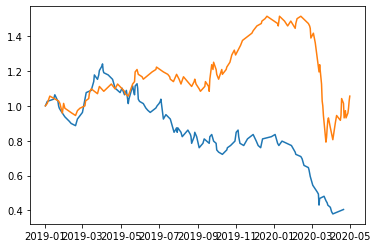

In [40]:
plt.plot(finalData['PNB']['ReClose']/finalData['PNB']['ReClose'][0])
plt.plot(finalData['ICICIBANK']['ReClose']/finalData['ICICIBANK']['ReClose'][0])

In [38]:
data['diff'] =(-1)*((data['PNB']['Close']/0.79)-(data['ICICIBANK']['Close']/3.60))

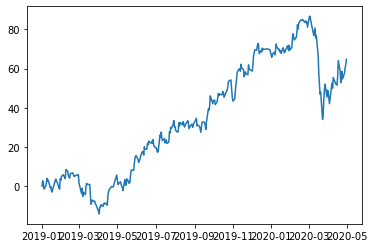

In [39]:
plt.plot(data['diff'])

In [23]:
df_a = pd.DataFrame.from_dict(data['PNB'])
df_a = df_a[['Open','High','Low','Close']]
#df_a = df_a.columns.drop('Date')
df_a = df_a.reset_index()
# date_a = df_a.index
# date_a = pd.to_datetime(date_a)
# df_a = df_a.reset_index()
# df_a['date'] = date_a
df_a.columns = [i.lower() for i in df_a.columns]

In [24]:
df_a.columns

Index(['date', 'open', 'high', 'low', 'close'], dtype='object')

In [25]:
df_b = pd.DataFrame.from_dict(data['ICICIBANK'])
df_b = df_b[['Open','High','Low','Close']]
df_b = df_b.reset_index()
# date_b = df_b.index
# date_b = pd.to_datetime(date_b)
# df_b = df_b.reset_index()
# df_b['date'] = date_b
df_b.columns = [i.lower() for i in df_b.columns]

In [26]:
df_b.columns

Index(['date', 'open', 'high', 'low', 'close'], dtype='object')

In [27]:
rows = 5

In [28]:
lb_a = indicators.LineBreak(df_a)

print('\n\nPNB Line break chart')
lb_a.line_number = 3
data_lb_a = lb_a.get_ohlc_data()
print(data_lb_a.tail(rows))

lb_b = indicators.LineBreak(df_b)

print('\n\nBAJAJ FINANCE Line break chart')
lb_b.line_number = 3
data_lb_b = lb_b.get_ohlc_data()
print(data_lb_b.tail(rows))



PNB Line break chart
     index       date       open       high        low      close  uptrend
111      0 2020-03-26  33.750000  33.750000  33.400002  33.400002    False
112      0 2020-03-30  33.400002  33.400002  32.900002  32.900002    False
113      0 2020-03-31  32.900002  32.900002  32.349998  32.349998    False
114      0 2020-04-01  32.349998  32.349998  30.450001  30.450001    False
115      0 2020-04-03  30.450001  30.450001  29.650000  29.650000    False


BAJAJ FINANCE Line break chart
    index       date        open        high         low       close  uptrend
91      0 2020-03-18  367.250000  367.250000  355.049988  355.049988    False
92      0 2020-03-19  355.049988  355.049988  338.549988  338.549988    False
93      0 2020-03-23  338.549988  338.549988  284.000000  284.000000    False
94      0 2020-04-17  338.549988  375.549988  338.549988  375.549988     True
95      0 2020-04-30  375.549988  380.149994  375.549988  380.149994     True


In [29]:
lb_chart_a = data_lb_a[['close']]
date_time_a = data_lb_a['date']
date_time_a = pd.to_datetime(date_time_a)
lb_chart_a = lb_chart_a.set_index(date_time_a)

lb_chart_b = data_lb_b[['close']]
date_time_b = data_lb_b['date']
date_time_b = pd.to_datetime(date_time_b)
lb_chart_b = lb_chart_b.set_index(date_time_b)

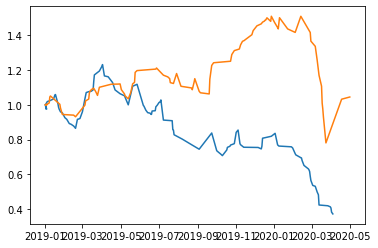

In [30]:
plt.plot(lb_chart_a/lb_chart_a['close'][0])
plt.plot(lb_chart_b/lb_chart_b['close'][0])


In [31]:
df1 = pd.DataFrame.from_dict(data['PNB'])
df2 = pd.DataFrame.from_dict(data['ICICIBANK'])

In [32]:
df1['ratio'] = (df1['Close']/df1['Close'][0])/(df2['Close']/df2['Close'][0])
df2['ratio'] = (df2['Close']/df2['Close'][0])/(df1['Close']/df1['Close'][0])

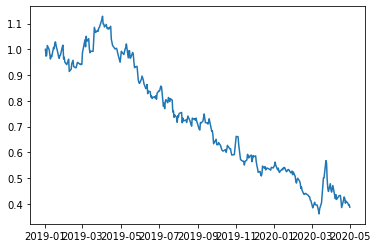

In [33]:
plt.plot(df1['ratio'])

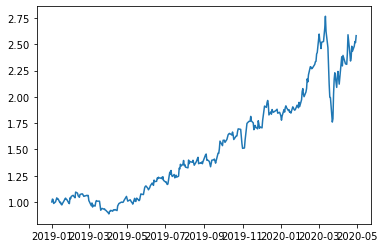

In [34]:
plt.plot(df2['ratio'])